In [ ]:
!pwd

/content


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import os
import numpy as np
import pandas as pd
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
import cv2
from scipy import stats
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

In [ ]:
# os.chdir allows you to change directories, like cd in the Terminal
os.chdir('/content/drive/MyDrive/Colab Notebooks/raw_data')

In [2]:
# Let's store the location of our data in 2 variables that we can re use later

train_data_dir = '/content/drive/MyDrive/Colab Notebooks/raw_data/Training'
test_data_dir = '/content/drive/MyDrive/Colab Notebooks/raw_data/Testing'

In [3]:
batch_size = 64

Here, we'll create a `Tensorflow Datasets` object. 
This will allow us to: 


*   Grab images from our directory batch by batch, we won't load the FULL data at the same time
*   Reshape all the images to our desired input shape, 255x255 in this recap

We have to specify different things:


*   Where the data is located (that's why we saved the folder name in a variable)
*   The target size to resize our images so they fit our model
*   The Batch size
*   The "label mode", here we say categorical, and the classes will be infered based on the folders name.
*   Here the labels are inferred based on the folder structure

In [6]:
train_ds, val_ds = image_dataset_from_directory(
  train_data_dir,
  labels = "inferred",
  label_mode = "categorical",
  seed=123,
  image_size=(255, 255),
  validation_split = 0.2,
  subset="both",
  color_mode = 'rgb',
  batch_size= batch_size)

# We define a second one for the test data

test_ds = image_dataset_from_directory(
  test_data_dir,
  labels = "inferred",
  label_mode = "categorical",
  seed=123,
  image_size=(255, 255),
  color_mode = 'rgb',
  batch_size= batch_size)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


In [7]:
class_names = train_ds.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


### Model with Transfer Learning  - VGG16

In [8]:
base_model = VGG16(weights = "imagenet", include_top = False, input_shape = (255, 255, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [9]:
# First step is to initialize the VGG16 model but without the top as we'll adapt it to our problem


inputs = layers.Input(shape = (255, 255, 3))

#x = data_augmentation(inputs) # We still have our data augmentation layers
x = preprocess_input(inputs) # Then a preprocessing layer specifically designed for the VGG16
x = base_model(x) # Then our transfer learning model

x = layers.Flatten()(x) # Followed by our custom dense layers, tailored to our binary task

x = layers.Dense(128, activation = "relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation = "relu")(x)
x = layers.Dropout(0.3)(x)
pred = layers.Dense(4, activation = "softmax")(x)

# We use the keras Functional API to create our keras model

model_1 = Model(inputs = inputs , outputs = pred)

# And we freeze the VGG16 model

base_model.trainable = False

In [10]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 255, 255, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 255, 255, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 255, 255, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                             

In [11]:
adam = optimizers.Adam(learning_rate = 0.001)
model_1.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

Here we'll create our callbacks. Those functions will be called at the end of every single epoch. 
We'll use: 


*   `ModelCheckpoint` to save the best version of our model after every epoch 
*   `ReduceLROnPlateau` to reduce the `learning_rate` if the model doesn't get better after a few epochs
*   `EarlyStopping` to stop the training after a certain time if it's not improving



In [12]:
MODEL = "model_1"

modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)

In [13]:
history_1 = model_1.fit(
        train_ds,
        epochs=40,
        validation_data=val_ds,
        callbacks = [modelCheckpoint, LRreducer, EarlyStopper])

Epoch 1/40
72/72 [==============================] - 518s 6s/step - loss: 3.2316 - accuracy: 0.6287 - val_loss: 0.6228 - val_accuracy: 0.8599 - lr: 0.0010
Epoch 2/40
72/72 [==============================] - 36s 479ms/step - loss: 0.7530 - accuracy: 0.7810 - val_loss: 0.5274 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 3/40
72/72 [==============================] - 32s 431ms/step - loss: 0.5965 - accuracy: 0.8162 - val_loss: 0.4181 - val_accuracy: 0.8993 - lr: 0.0010
Epoch 4/40
72/72 [==============================] - 33s 437ms/step - loss: 0.4426 - accuracy: 0.8593 - val_loss: 0.3761 - val_accuracy: 0.9089 - lr: 0.0010
Epoch 5/40
72/72 [==============================] - 33s 442ms/step - loss: 0.4855 - accuracy: 0.8418 - val_loss: 0.4509 - val_accuracy: 0.8905 - lr: 0.0010
Epoch 6/40
72/72 [==============================] - 37s 499ms/step - loss: 0.4145 - accuracy: 0.8613 - val_loss: 0.4329 - val_accuracy: 0.9054 - lr: 0.0010
Epoch 7/40
72/72 [==============================] - 34s 450ms/step

In [14]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

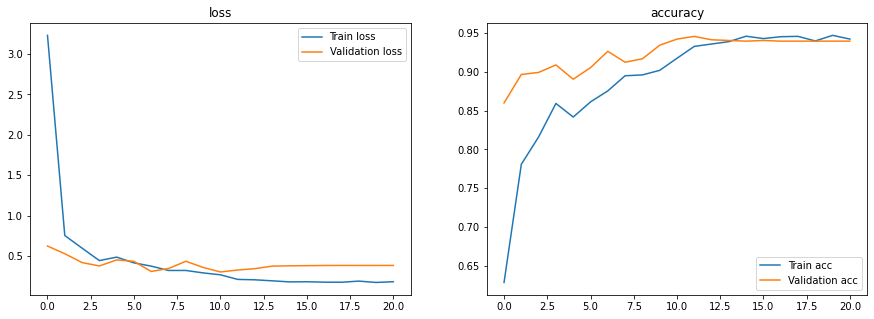

In [15]:
plot_history(history_1)

In [16]:
model_1.evaluate(test_ds)

21/21 [==============================] - 118s 3s/step - loss: 0.3849 - accuracy: 0.9191


[0.38487136363983154, 0.9191457033157349]

In [22]:
import tensorflow as tf

In [26]:
#Model save
tf.keras.models.save_model(model_1, 'VGG16.h5')

In [ ]:
from PIL import Image
import requests
from io import BytesIO

In [27]:
model_dir = os.path.dirname(os.path.abspath('my_model.h5'))
print("Saved model location:", model_dir)

Saved model location: /content


In [ ]:
#model_1.save(VGG16.h5)